## Detalle sobre este notebook (fv_periodo):
* Este notebook utiliza los programas presidenciales del cualquier período de 5 años, los compara según su correlación por temas etiquetados, por país.
* Selecciona un Feature Vector acotado
* Construye una red de similaridad.
* Luego identifica comunidades.
* Luego estima métricas de centralidad
* al final tiene conclusiones sobre el período #15 (1990-1994)

#### Librerías

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
from networkx.algorithms import community
import community as community_louvain


#### Cargar df_5_extended

In [2]:
df_5_extended = pd.read_excel('df_5_extended.xlsx')
df_5_extended.head()

countryname  ventana_5    per101   per102    per103    per104    per105  \
0     Albania         15  3.113815  0.00000  1.559835  2.046771  0.331285   
1     Albania         16  3.716797  0.00000  0.051879  3.519091  0.015910   
2     Albania         17  2.392570  0.00000  0.000000  2.757403  0.026619   
3   Argentina         14  0.000000  0.00000  4.619213  0.448618  0.828036   
4   Argentina         16  0.254185  0.02014  0.725611  1.406834  0.100835   

     per106    per107    per108  ...  per606_1  per606_2  per607_1  per607_2  \
0  1.674371  4.632186  5.169904  ...  0.000000       0.0  0.000000       0.0   
1  0.579077  4.971347  1.981720  ...  0.000000       0.0  0.000000       0.0   
2  0.023948  3.523162  1.452779  ...  0.000000       0.0  0.000000       0.0   
3  0.338070  2.955090  0.000000  ...  7.595332       0.0  0.326532       0.0   
4  1.720736  5.478894  3.932102  ...  4.494125       0.0  0.443809       0.0   

   per607_3  per608_1  per608_2  per608_3  per703_1  per703_2  
0  0.000000       0.0       0.0       0.0  0.000000       0.0  
1  0.000000       0.0       0.0       0.0  0.000000       0.0  
2  0.000000       0.0       0.0       0.0  0.000000       0.0  
3  0.000000       0.0       0.0       0.0  2.495280       0.0  
4  0.809128       0.0       0.0       0.0  2.573783       0.0  

[5 rows x 144 columns]

In [3]:
df_5_extended.shape

(1407, 144)

In [4]:
# cargar Analytical_Data
df_AD = pd.read_excel('data/Analytical_Data.xlsx')
df_AD.head()


Dominio      Nombre_Dominio Variable_per  \
0  Domain_1  External Relations       per101   
1  Domain_1  External Relations       per102   
2  Domain_1  External Relations       per103   
3  Domain_1  External Relations       per104   
4  Domain_1  External Relations       per105   

                           Detalle_Dominio  
0  Foreign Special Relationships: Positive  
1  Foreign Special Relationships: Negative  
2                         Anti-Imperialism  
3                       Military: Positive  
4                       Military: Negative

In [5]:
all_per_variables = [col for col in df_5_extended.columns if col.startswith('per')]
all_per_variables

['per101',
 'per102',
 'per103',
 'per104',
 'per105',
 'per106',
 'per107',
 'per108',
 'per109',
 'per110',
 'per201',
 'per202',
 'per203',
 'per204',
 'per301',
 'per302',
 'per303',
 'per304',
 'per305',
 'per401',
 'per402',
 'per403',
 'per404',
 'per405',
 'per406',
 'per407',
 'per408',
 'per409',
 'per410',
 'per411',
 'per412',
 'per413',
 'per414',
 'per415',
 'per416',
 'per501',
 'per502',
 'per503',
 'per504',
 'per505',
 'per506',
 'per507',
 'per601',
 'per602',
 'per603',
 'per604',
 'per605',
 'per606',
 'per607',
 'per608',
 'per701',
 'per702',
 'per703',
 'per704',
 'per705',
 'per706',
 'per1011',
 'per1012',
 'per1013',
 'per1014',
 'per1015',
 'per1016',
 'per1021',
 'per1022',
 'per1023',
 'per1024',
 'per1025',
 'per1026',
 'per1031',
 'per1032',
 'per1033',
 'per2021',
 'per2022',
 'per2023',
 'per2031',
 'per2032',
 'per2033',
 'per2041',
 'per3011',
 'per3051',
 'per3052',
 'per3053',
 'per3054',
 'per3055',
 'per4011',
 'per4012',
 'per4013',
 'per4014',


In [6]:
len(all_per_variables)

142

#### 1. TRABAJO CON ASPECTOS PARTICULARES
   * Crearemos una lista de nombres de 'aspectos' junto con una lista de nombres de variables que lo explican
   * Consolidaremos 'df_5_extended' para que incluya solamente las volumnas de interés para cada aspecto.


#### 1.1 Lista de aspectos y variables de interés
* Aspecto específicos:
       
*          * Inclusión y Minorías
*          * Orden y Corrupción
*          * Medio Ambiente y Sostenibilidad
*          * Pueblos Originarios
*          * Derechos Humanos
*          * Inmigración
*          * Moral Tradicional 


#### Correlación de Pearson

**Qué es**: La correlación de Pearson mide la relación lineal entre dos conjuntos de datos. En este caso, mediría cómo se correlacionan los porcentajes de las etiquetas temáticas entre dos programas de gobierno.

**Aplicación**: Para cada par de programas de gobierno (por ejemplo, "Chile_1990" y "Alemania_1980"), calcula la correlación de Pearson usando sus respectivos vectores de porcentajes de las 56 etiquetas temáticas.

Si el vector de "Chile_1990" es `[x1,x2,...,x56]` y el de "Alemania_1980" es `[y1,y2,...,y56]`, entonces la correlación de Pearson se calcula como:

$$
r = \frac{\sum_{i=1}^{56} (x_i - \bar{x})(y_i - \bar{y})}{\sqrt{\sum_{i=1}^{56} (x_i - \bar{x})^2} \cdot \sqrt{\sum_{i=1}^{56} (y_i - \bar{y})^2}}
$$

Donde $\bar{x}$ y $\bar{y}$ son las medias de los vectores de porcentajes.

#### Interpretación de la Correlación:
El valor de $r$ está en el rango $[-1,1]$, donde:

- $r = 1$ indica una correlación positiva perfecta (discursos muy similares en la distribución temática).
- $r = -1$ indica una correlación negativa perfecta (discursos temáticamente opuestos).
- $r \approx 0$ indica que no hay una correlación lineal significativa.

#### Uso en la Red de Similaridad:
Usaremos el valor absoluto de la correlación ($|r|$) para ponderar la arista entre dos programas. Valores cercanos a 1 indican una fuerte similaridad temática, mientras que valores cercanos a 0 indican poca o ninguna similaridad.

---


#### Aspectos

In [7]:
# Crear el DataFrame 'df_aspectos' con los aspectos y las variables asociadas
data_aspectos = {
    'aspecto': ['Inclusion_y_Minorias', 'Orden_y_Corrupcion', 'Medio_Ambiente_y_Sostenibilidad'],
    'var_1': ['per503', 'per605_1', 'per503'],
    'var_2': ['per705', 'per605_2', 'per705'],
    'var_3': ['per201_2', 'per304', 'per201_2'],  # None indica que no hay una tercera variable para el aspecto
    'var_4': [None, None, None]  # Ningún aspecto tiene cuarta variable
}

df_aspectos = pd.DataFrame(data_aspectos)

# Mostrar el DataFrame 'df_aspectos' para verificar su contenido
display(df_aspectos)

aspecto     var_1     var_2     var_3 var_4
0             Inclusion_y_Minorias    per503    per705  per201_2  None
1               Orden_y_Corrupcion  per605_1  per605_2    per304  None
2  Medio_Ambiente_y_Sostenibilidad    per503    per705  per201_2  None

#### Calculamos la similaridad tanto con correlación como con distancia euclideana

In [20]:
import pandas as pd
import numpy as np
from collections import defaultdict
from scipy.spatial.distance import euclidean
import warnings

def calcular_similitud(df, df_aspectos, porcentaje, periodo):
    """Calcula la similaridad entre Chile y otros países para un período específico, utilizando correlación de Spearman y distancia euclideana."""
    similarity_results_spearman = defaultdict(list)
    similarity_results_euclidean = defaultdict(list)
    constantes = []  # Almacena países_período con valores constantes
    
    # Filtrar el dataframe para el período específico
    df = df[df['ventana_5'] == periodo]
    
    for _, row_aspecto in df_aspectos.iterrows():
        aspecto = row_aspecto['aspecto']
        variables = row_aspecto[['var_1', 'var_2', 'var_3', 'var_4']].dropna().tolist()
        
        columnas_relevantes = ['countryname', 'ventana_5'] + variables
        df_chile = df[df['countryname'] == 'Chile'][columnas_relevantes].copy()
        df_otros = df[df['countryname'] != 'Chile'][columnas_relevantes].copy()
        
        for _, row in df_otros.iterrows():
            country_period = row['countryname'] + '_' + str(row['ventana_5'])
            country_data = row[variables].dropna().astype(float)
            chile_periods = df_chile[df_chile['ventana_5'] >= row['ventana_5']]
            
            for _, chile_row in chile_periods.iterrows():
                chile_period = 'Chile_' + str(chile_row['ventana_5'])
                chile_data = chile_row[variables].dropna().astype(float)
                
                if len(country_data) == len(chile_data):
                    with warnings.catch_warnings(record=True) as w:
                        warnings.simplefilter("always")
                        spearman_corr = country_data.corr(chile_data, method='spearman')
                        spearman_corr = 0 if pd.isna(spearman_corr) else spearman_corr

                        # Verificar si alguna advertencia contiene 'An input array is constant'
                        for warn in w:
                            if "An input array is constant" in str(warn.message):
                                constantes.append(country_period)
                                spearman_corr = 0  # Asignamos 0 en caso de valores constantes

                    euclidean_dist = euclidean(country_data, chile_data)
                    euclidean_similarity = 1 / (1 + euclidean_dist)
                else:
                    spearman_corr = 0
                    euclidean_similarity = 0

                similarity_results_spearman[(aspecto, country_period, chile_period)].append(spearman_corr)
                similarity_results_euclidean[(aspecto, country_period, chile_period)].append(euclidean_similarity)

    # Mostramos los casos con valores constantes
    if constantes:
        print("Países_Período con valores constantes en los datos:")
        print(set(constantes))

    final_results_spearman = {key: np.mean(values) for key, values in similarity_results_spearman.items()}
    final_results_euclidean = {key: np.mean(values) for key, values in similarity_results_euclidean.items()}

    # Crear dataframes con las columnas necesarias
    df_similarity_spearman = pd.DataFrame(
        list(final_results_spearman.items()), 
        columns=['Aspecto_Country_Period_And_Chile_Period', 'Spearman_Similarity']
    )
    df_similarity_euclidean = pd.DataFrame(
        list(final_results_euclidean.items()), 
        columns=['Aspecto_Country_Period_And_Chile_Period', 'Euclidean_Similarity']
    )
    
    # Separar las columnas 'Country_Period' y 'Chile_Period'
    df_similarity_spearman[['Aspecto', 'Country_Period', 'Chile_Period']] = pd.DataFrame(
        df_similarity_spearman['Aspecto_Country_Period_And_Chile_Period'].tolist(), index=df_similarity_spearman.index
    )
    df_similarity_euclidean[['Aspecto', 'Country_Period', 'Chile_Period']] = pd.DataFrame(
        df_similarity_euclidean['Aspecto_Country_Period_And_Chile_Period'].tolist(), index=df_similarity_euclidean.index
    )

    df_similarity_spearman.drop('Aspecto_Country_Period_And_Chile_Period', axis=1, inplace=True)
    df_similarity_euclidean.drop('Aspecto_Country_Period_And_Chile_Period', axis=1, inplace=True)
    
    return df_similarity_spearman, df_similarity_euclidean


#### Generamos las Redes, Comunidades y Métricas de Centralidad

In [21]:
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms import community
import seaborn as sns

def generar_red_y_calcular_metricas(df_similarity, aspecto, tipo_similitud, porcentaje):
    # Filtramos los x% enlaces con mayor similaridad
    df_similarity = df_similarity.sort_values(by=tipo_similitud, ascending=False)
    top_x_percent = int(len(df_similarity) * (porcentaje / 100))
    df_top_similarity = df_similarity.head(top_x_percent)

    # Agrupamos duplicados promediando los valores de similaridad para cada par único
    df_top_similarity = df_top_similarity.groupby(['Country_Period', 'Chile_Period'], as_index=False).agg({tipo_similitud: 'mean'})
    
    # Generamos el heatmap de similaridad
    try:
        heatmap_data = df_top_similarity.pivot(index='Country_Period', columns='Chile_Period', values=tipo_similitud)
        plt.figure(figsize=(12, 8))
        sns.heatmap(heatmap_data, annot=True, cmap="coolwarm", linewidths=0.5, linecolor='gray', cbar_kws={'label': f'Similitud ({tipo_similitud})'})
        plt.title(f'Heatmap - {aspecto} ({porcentaje}% enlaces más fuertes)')
        plt.show()
    except ValueError as e:
        print(f"Error al crear el heatmap: {e}. Verifique que no haya demasiados valores duplicados.")
    
    # Construcción de la red
    G = nx.Graph()
    for _, row in df_top_similarity.iterrows():
        nodo_chile = row['Chile_Period']
        nodo_pais = row['Country_Period']
        G.add_edge(nodo_chile, nodo_pais, weight=row[tipo_similitud])
    
    # Visualización de la red de similaridad
    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(G, k=0.5, seed=42)
    nx.draw(G, pos, with_labels=True, node_size=3000, node_color='lightblue', edge_color='gray', width=2)
    plt.title(f'Red de Similitud - {aspecto} ({porcentaje}% enlaces más fuertes)')
    plt.show()
    
    # Clustering y cálculo de métricas de centralidad
    partition = community.louvain_communities(G, weight='weight')
    num_clusters = len(partition)
    print(f"Se identificaron {num_clusters} clusters para el aspecto '{aspecto}'.")

    # Visualización del gráfico de comunidades
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G, seed=42)
    for i, comm in enumerate(partition):
        nx.draw_networkx_nodes(G, pos, nodelist=list(comm), node_size=300, label=f'Comunidad {i}')
    nx.draw_networkx_edges(G, pos, alpha=0.5, edge_color="gray")
    nx.draw_networkx_labels(G, pos, font_size=8)
    plt.title(f'Comunidades detectadas - {aspecto}')
    plt.legend(loc="best")
    plt.show()

    # Cálculo de métricas de centralidad
    degree = nx.degree_centrality(G)
    betweenness = nx.betweenness_centrality(G, weight='weight')
    eigenvector = nx.eigenvector_centrality(G, max_iter=1000)

    df_centralities = pd.DataFrame({
        'Nodo': list(degree.keys()),
        'Degree_Centrality': list(degree.values()),
        'Betweenness_Centrality': list(betweenness.values()),
        'Eigenvector_Centrality': list(eigenvector.values()),
        'Aspecto': aspecto
    })
    
    return df_centralities


#### Ejecución


Analizando: Inclusion_y_Minorias en el período 15
Países_Período con valores constantes en los datos:
{'Luxembourg_15', 'Malta_15', 'Uruguay_15', 'Azerbaijan_15', 'Armenia_15', 'Sri Lanka_15', 'Cyprus_15', 'Colombia_15', 'Belarus_15', 'Sweden_15', 'Peru_15', 'Ecuador_15', 'Norway_15', 'Bolivia_15', 'North Macedonia_15', 'Argentina_15', 'Dominican Republic_15', 'Northern Ireland_15'}
Generando análisis para correlación de Spearman en Inclusion_y_Minorias


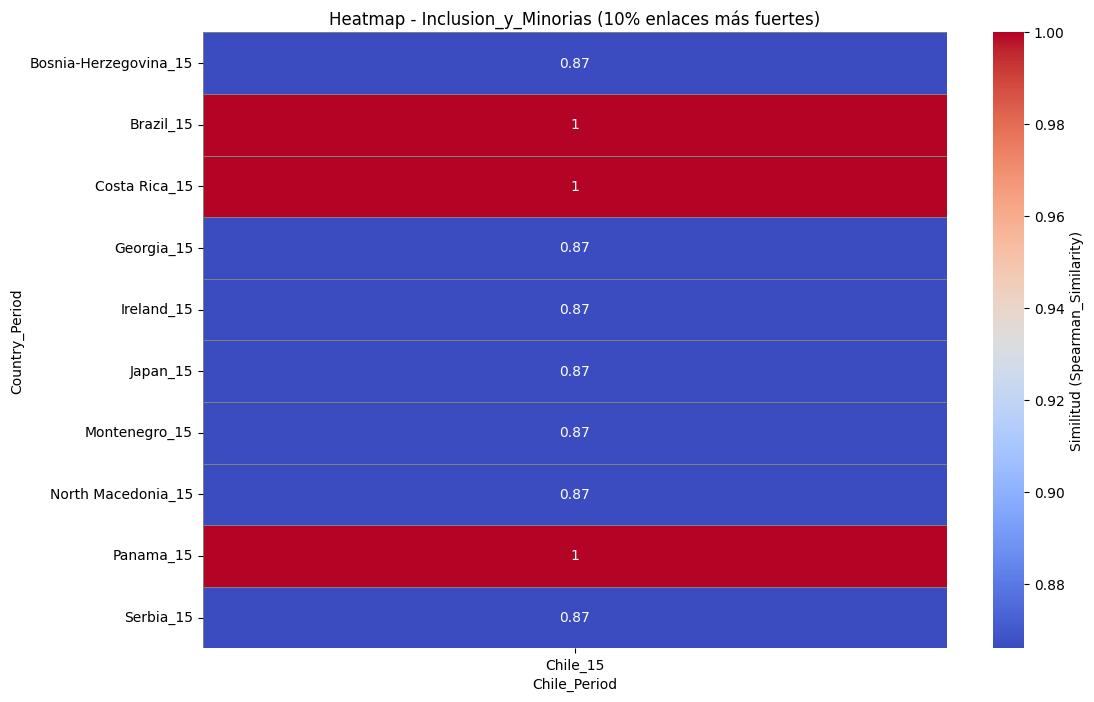

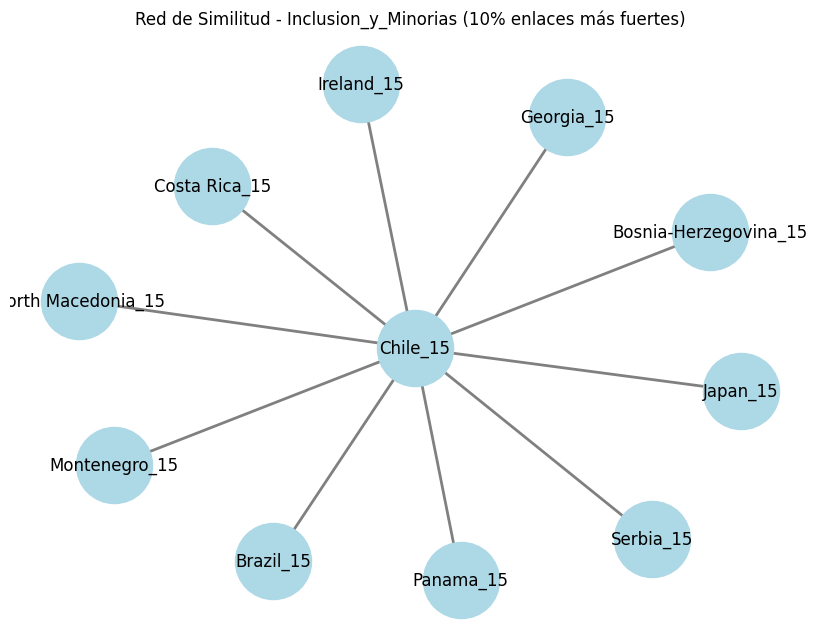

Se identificaron 1 clusters para el aspecto 'Inclusion_y_Minorias'.


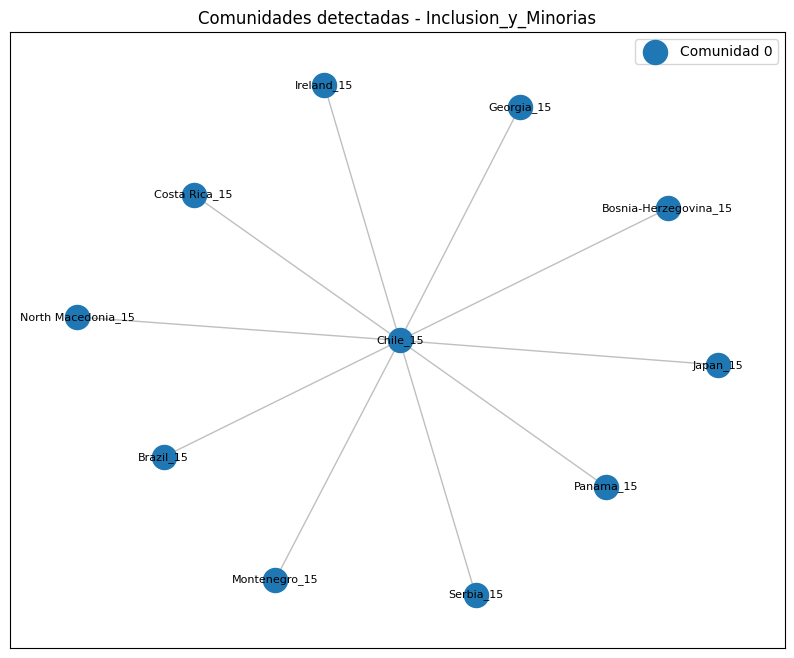

                    Nodo  Degree_Centrality  Betweenness_Centrality  \
0               Chile_15                1.0                     1.0   
1  Bosnia-Herzegovina_15                0.1                     0.0   
2              Brazil_15                0.1                     0.0   
3          Costa Rica_15                0.1                     0.0   
4             Georgia_15                0.1                     0.0   

   Eigenvector_Centrality               Aspecto  
0                0.707106  Inclusion_y_Minorias  
1                0.223607  Inclusion_y_Minorias  
2                0.223607  Inclusion_y_Minorias  
3                0.223607  Inclusion_y_Minorias  
4                0.223607  Inclusion_y_Minorias  
Generando análisis para distancia Euclideana en Inclusion_y_Minorias


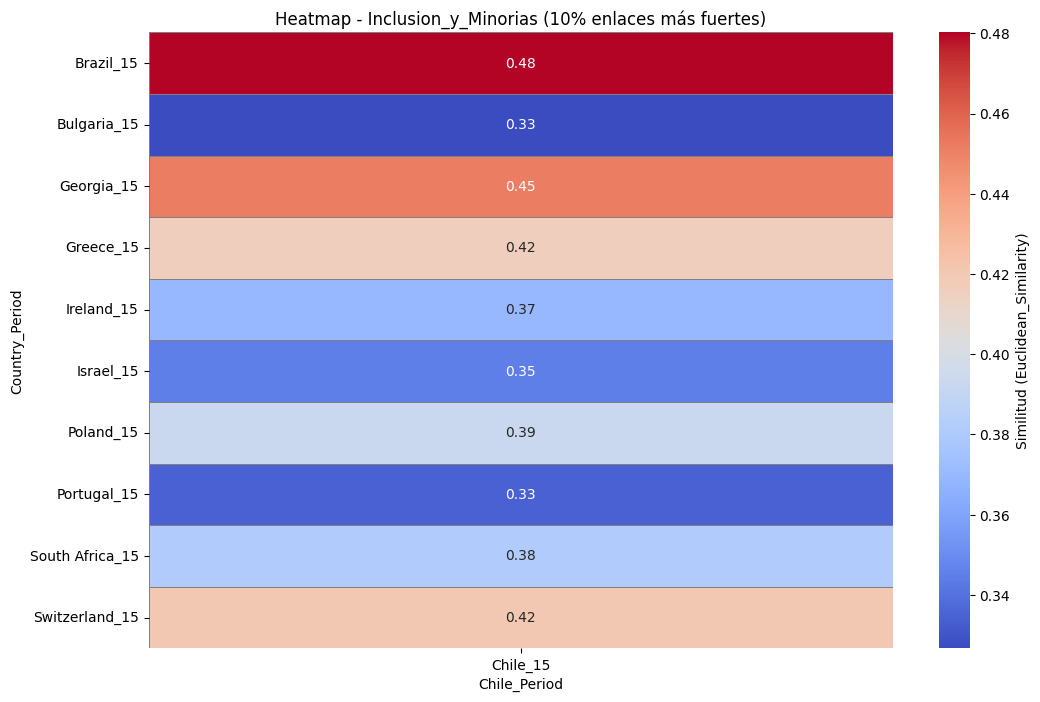

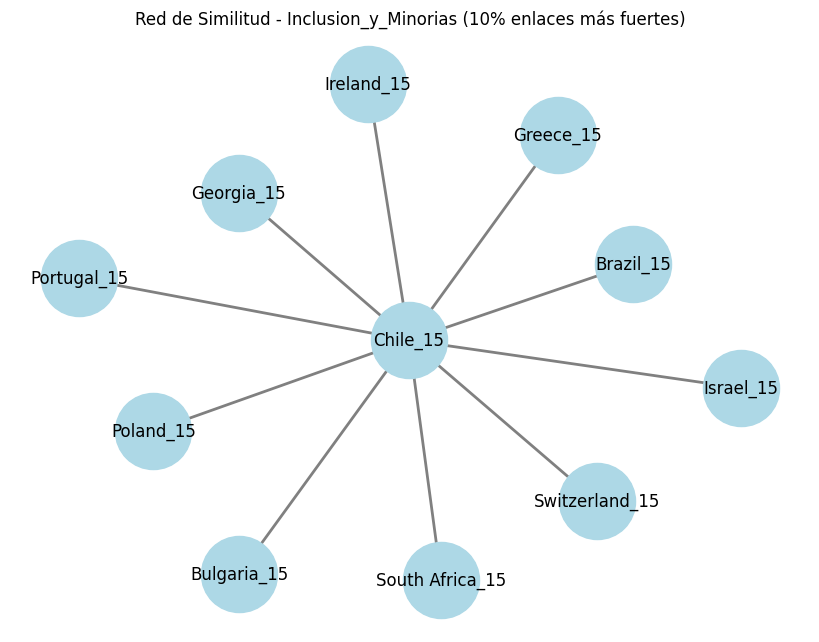

Se identificaron 1 clusters para el aspecto 'Inclusion_y_Minorias'.


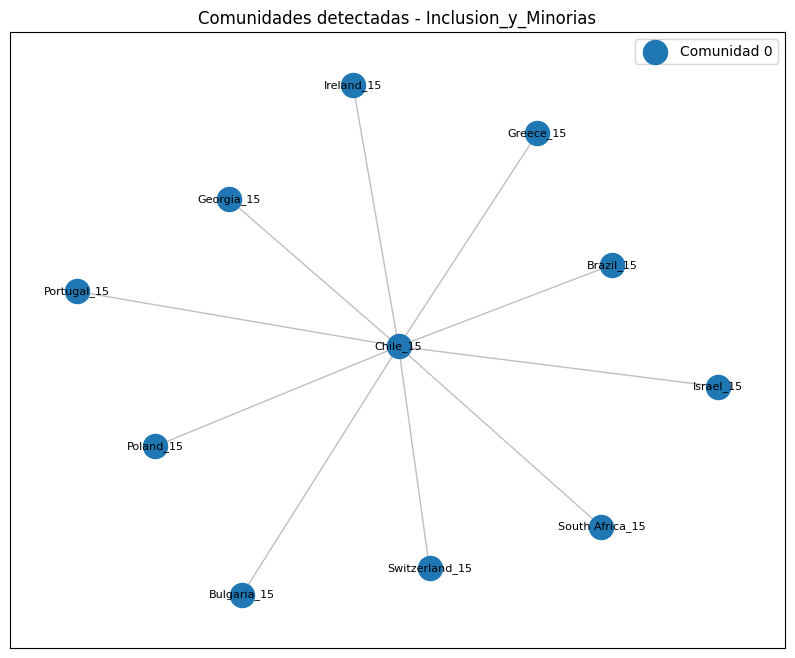

          Nodo  Degree_Centrality  Betweenness_Centrality  \
0     Chile_15                1.0                     1.0   
1    Brazil_15                0.1                     0.0   
2  Bulgaria_15                0.1                     0.0   
3   Georgia_15                0.1                     0.0   
4    Greece_15                0.1                     0.0   

   Eigenvector_Centrality               Aspecto  
0                0.707106  Inclusion_y_Minorias  
1                0.223607  Inclusion_y_Minorias  
2                0.223607  Inclusion_y_Minorias  
3                0.223607  Inclusion_y_Minorias  
4                0.223607  Inclusion_y_Minorias  

Analizando: Orden_y_Corrupcion en el período 15
Países_Período con valores constantes en los datos:
{'Luxembourg_15', 'Malta_15', 'Uruguay_15', 'Azerbaijan_15', 'Armenia_15', 'Sri Lanka_15', 'Cyprus_15', 'Colombia_15', 'Belarus_15', 'Sweden_15', 'Peru_15', 'Ecuador_15', 'Norway_15', 'Bolivia_15', 'North Macedonia_15', 'Argentina_1

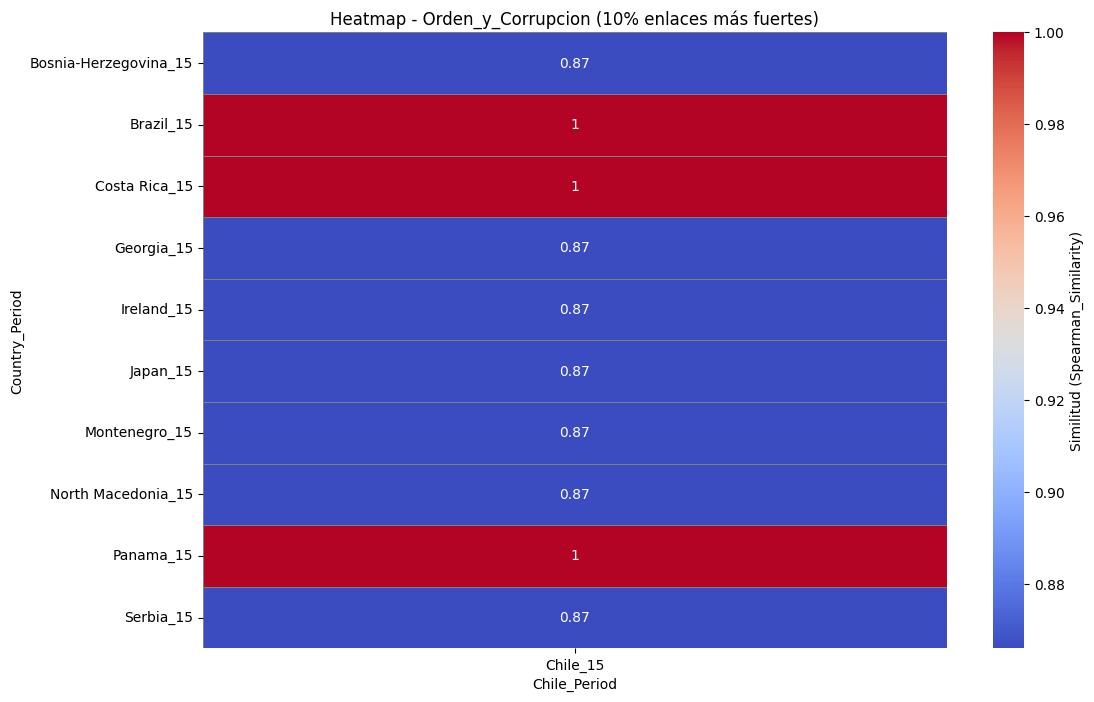

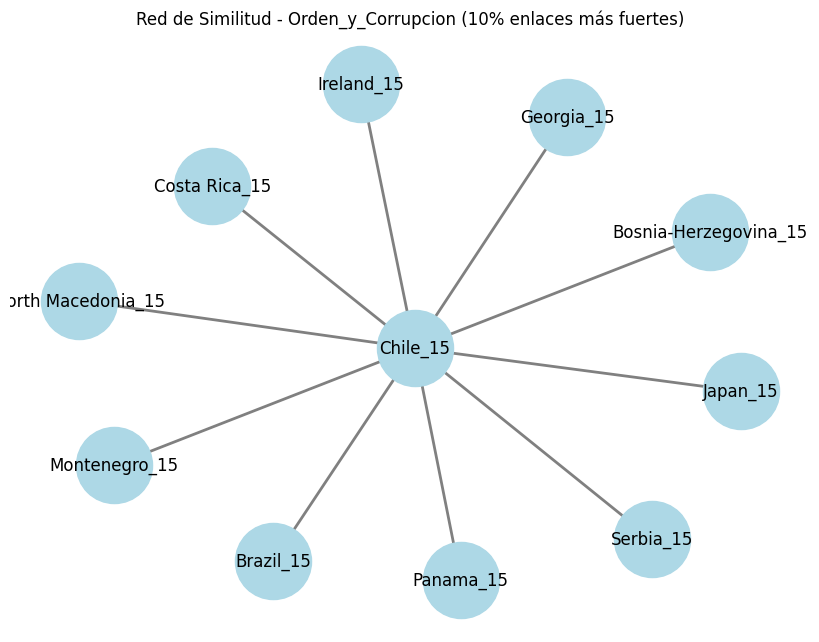

Se identificaron 1 clusters para el aspecto 'Orden_y_Corrupcion'.


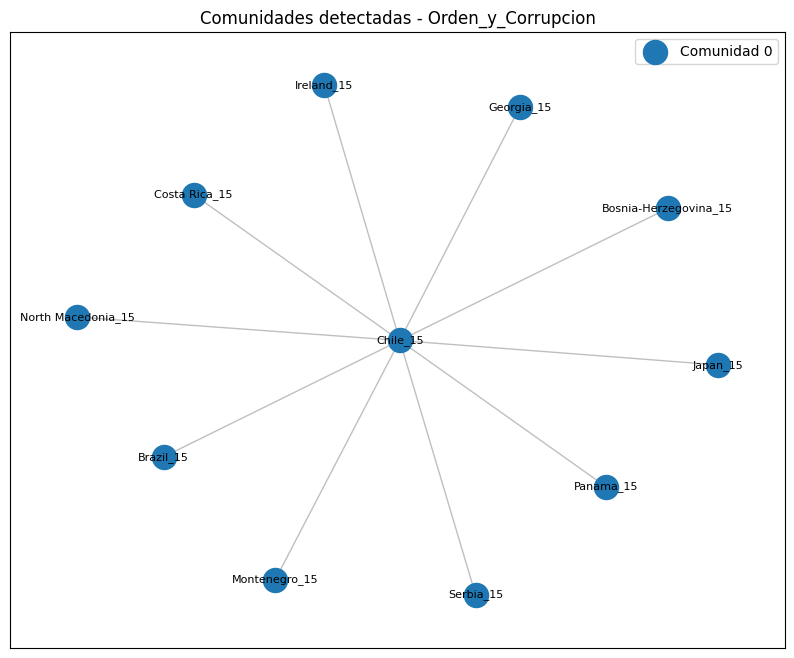

                    Nodo  Degree_Centrality  Betweenness_Centrality  \
0               Chile_15                1.0                     1.0   
1  Bosnia-Herzegovina_15                0.1                     0.0   
2              Brazil_15                0.1                     0.0   
3          Costa Rica_15                0.1                     0.0   
4             Georgia_15                0.1                     0.0   

   Eigenvector_Centrality             Aspecto  
0                0.707106  Orden_y_Corrupcion  
1                0.223607  Orden_y_Corrupcion  
2                0.223607  Orden_y_Corrupcion  
3                0.223607  Orden_y_Corrupcion  
4                0.223607  Orden_y_Corrupcion  
Generando análisis para distancia Euclideana en Orden_y_Corrupcion


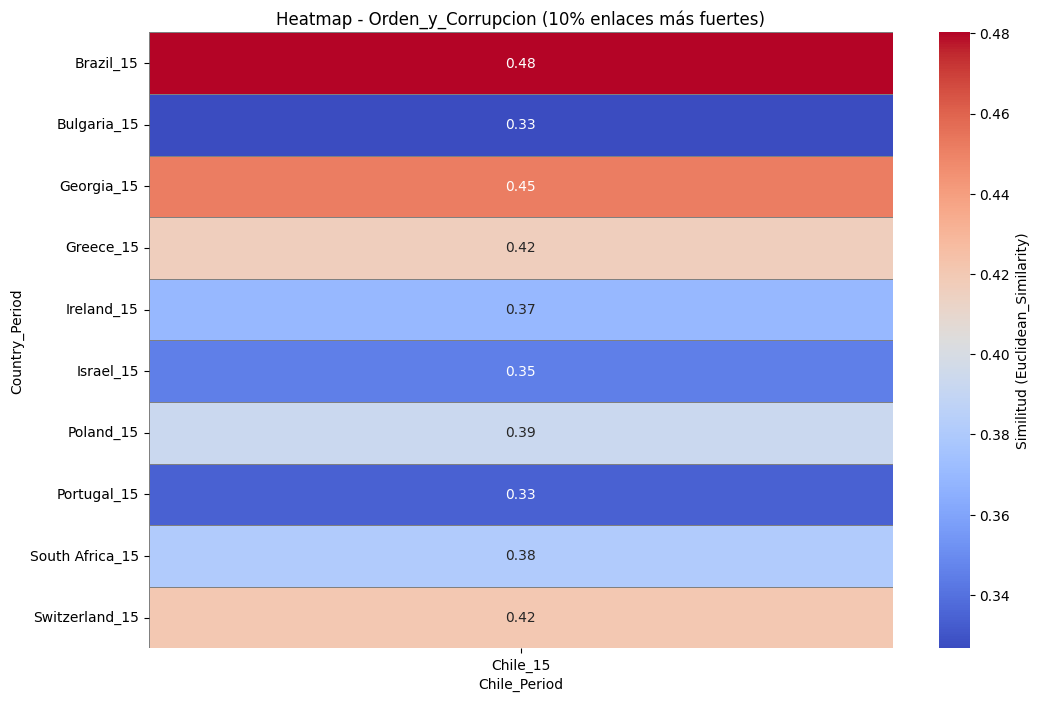

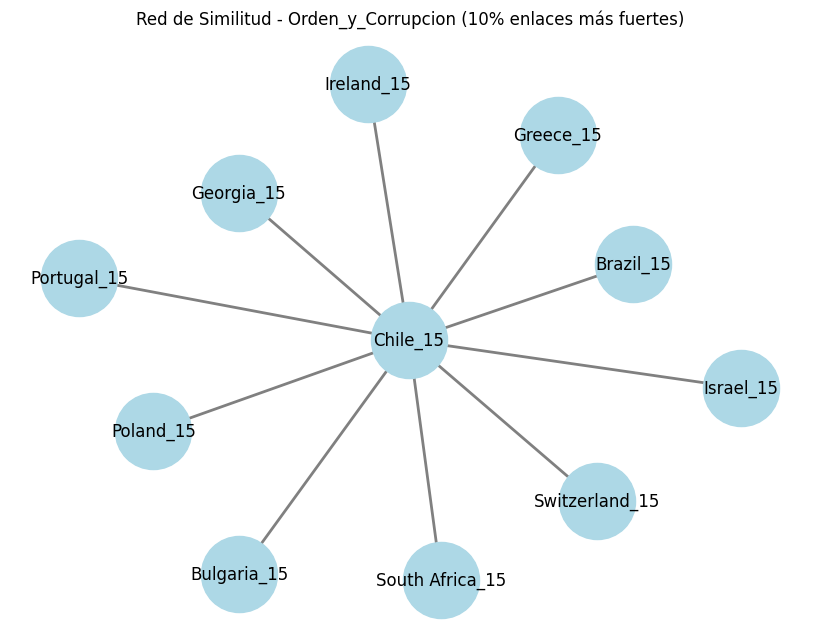

Se identificaron 1 clusters para el aspecto 'Orden_y_Corrupcion'.


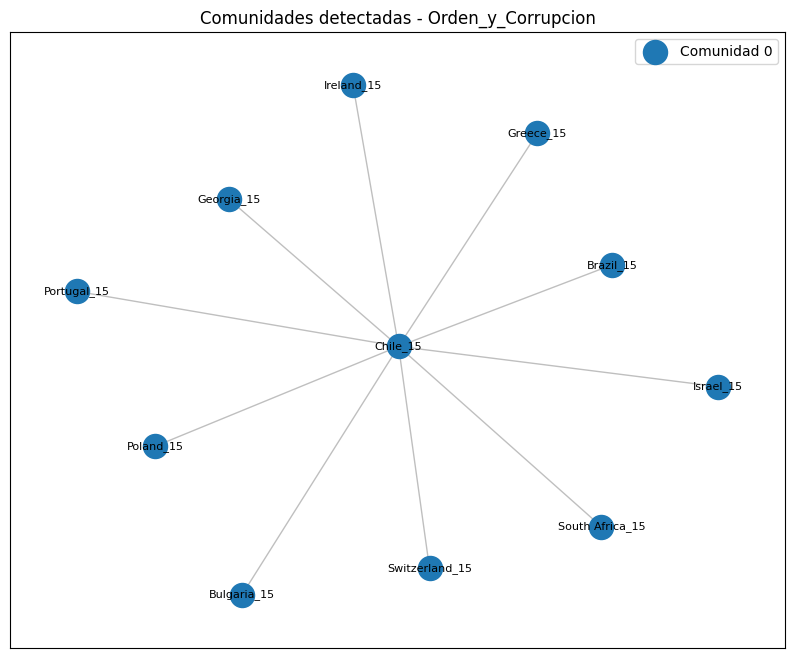

          Nodo  Degree_Centrality  Betweenness_Centrality  \
0     Chile_15                1.0                     1.0   
1    Brazil_15                0.1                     0.0   
2  Bulgaria_15                0.1                     0.0   
3   Georgia_15                0.1                     0.0   
4    Greece_15                0.1                     0.0   

   Eigenvector_Centrality             Aspecto  
0                0.707106  Orden_y_Corrupcion  
1                0.223607  Orden_y_Corrupcion  
2                0.223607  Orden_y_Corrupcion  
3                0.223607  Orden_y_Corrupcion  
4                0.223607  Orden_y_Corrupcion  

Analizando: Medio_Ambiente_y_Sostenibilidad en el período 15
Países_Período con valores constantes en los datos:
{'Luxembourg_15', 'Malta_15', 'Uruguay_15', 'Azerbaijan_15', 'Armenia_15', 'Sri Lanka_15', 'Cyprus_15', 'Colombia_15', 'Belarus_15', 'Sweden_15', 'Peru_15', 'Ecuador_15', 'Norway_15', 'Bolivia_15', 'North Macedonia_15', 'Argentina_

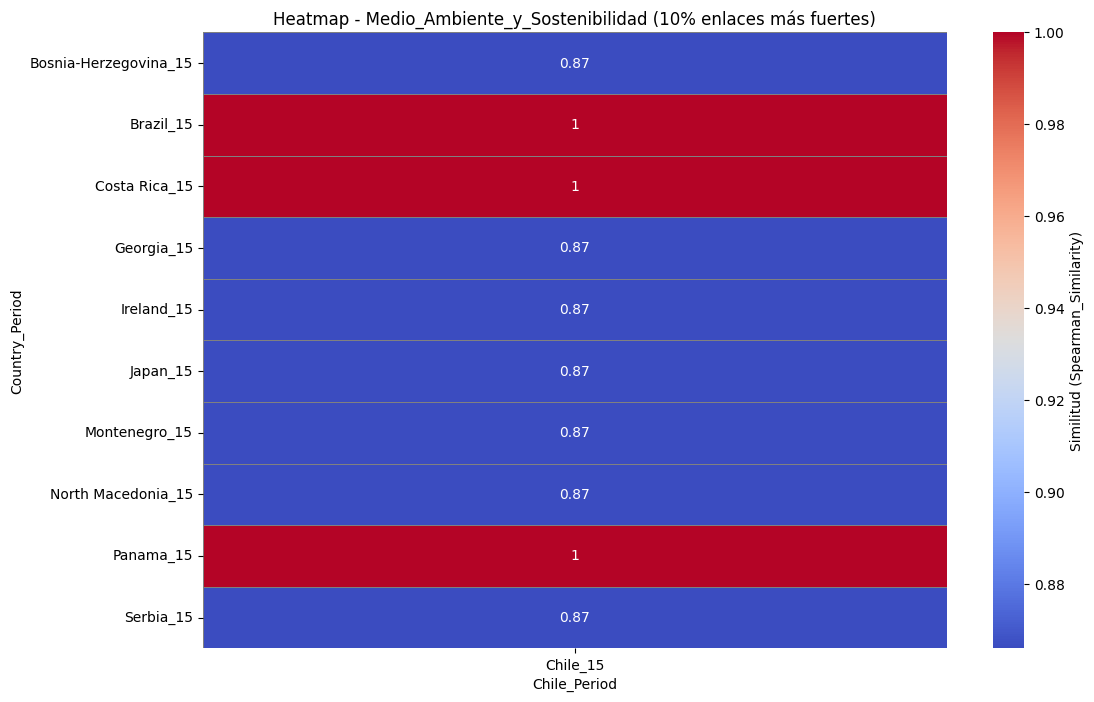

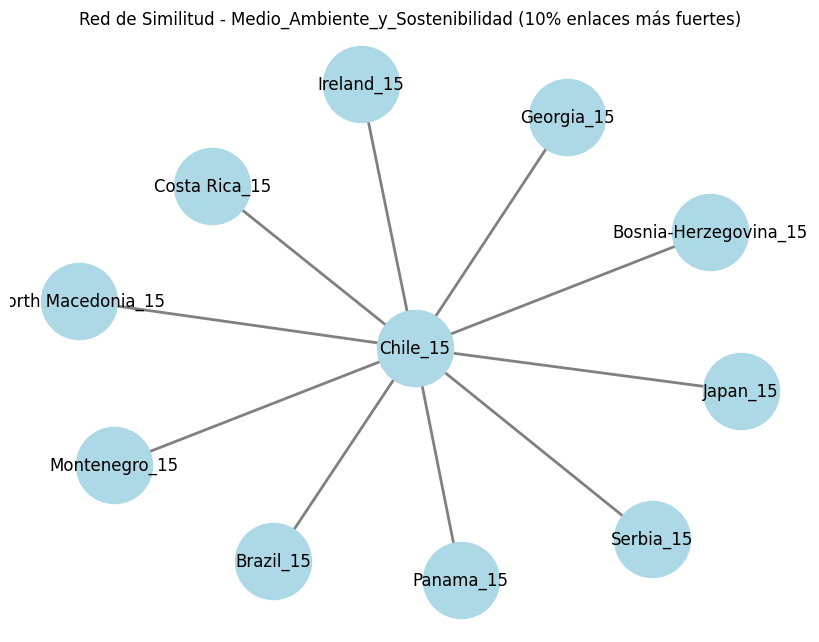

Se identificaron 1 clusters para el aspecto 'Medio_Ambiente_y_Sostenibilidad'.


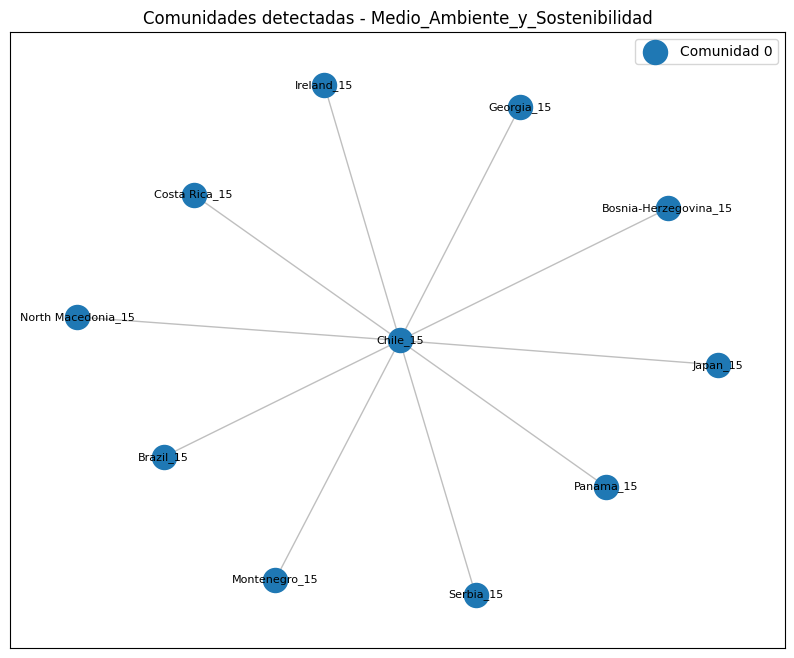

                    Nodo  Degree_Centrality  Betweenness_Centrality  \
0               Chile_15                1.0                     1.0   
1  Bosnia-Herzegovina_15                0.1                     0.0   
2              Brazil_15                0.1                     0.0   
3          Costa Rica_15                0.1                     0.0   
4             Georgia_15                0.1                     0.0   

   Eigenvector_Centrality                          Aspecto  
0                0.707106  Medio_Ambiente_y_Sostenibilidad  
1                0.223607  Medio_Ambiente_y_Sostenibilidad  
2                0.223607  Medio_Ambiente_y_Sostenibilidad  
3                0.223607  Medio_Ambiente_y_Sostenibilidad  
4                0.223607  Medio_Ambiente_y_Sostenibilidad  
Generando análisis para distancia Euclideana en Medio_Ambiente_y_Sostenibilidad


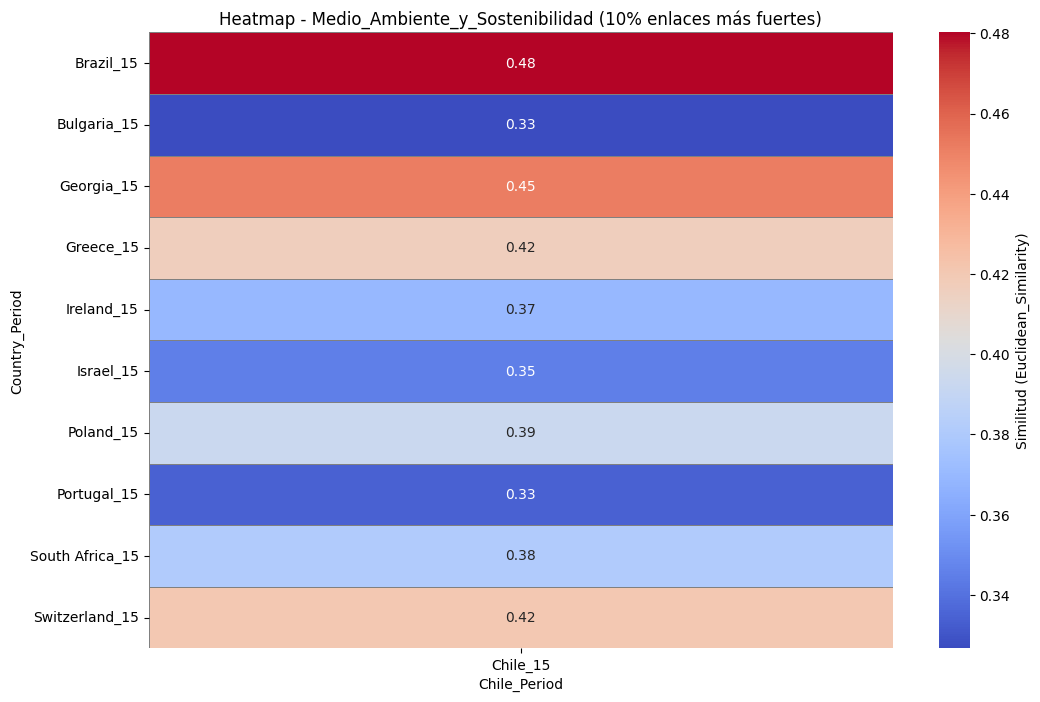

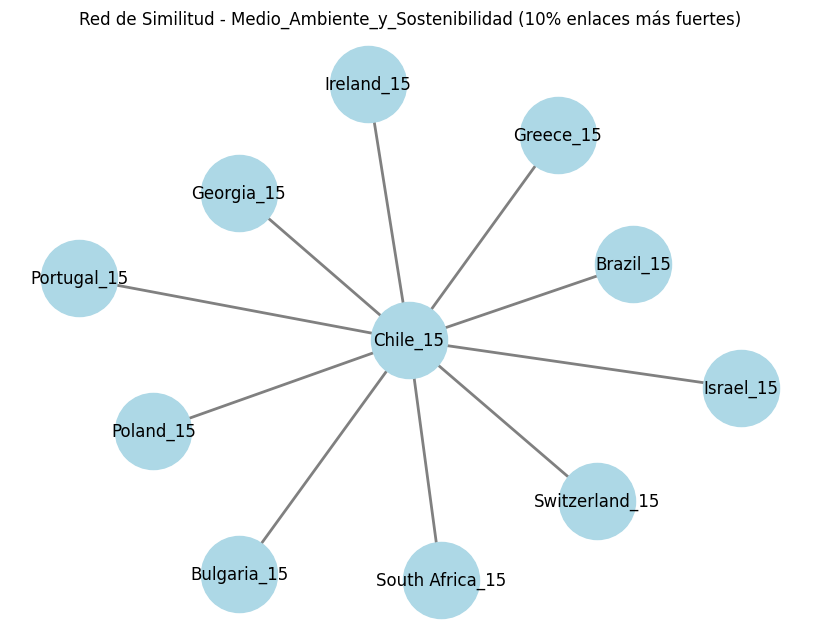

Se identificaron 1 clusters para el aspecto 'Medio_Ambiente_y_Sostenibilidad'.


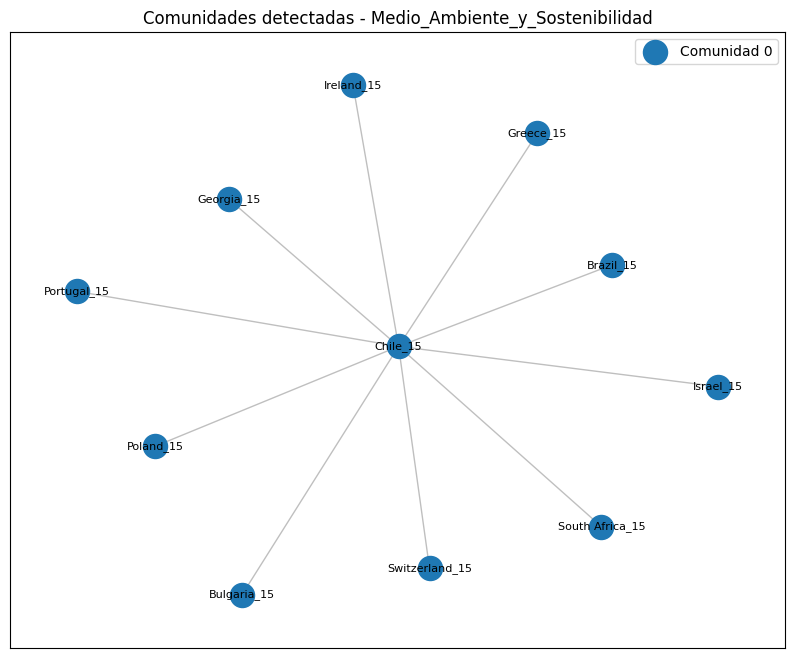

          Nodo  Degree_Centrality  Betweenness_Centrality  \
0     Chile_15                1.0                     1.0   
1    Brazil_15                0.1                     0.0   
2  Bulgaria_15                0.1                     0.0   
3   Georgia_15                0.1                     0.0   
4    Greece_15                0.1                     0.0   

   Eigenvector_Centrality                          Aspecto  
0                0.707106  Medio_Ambiente_y_Sostenibilidad  
1                0.223607  Medio_Ambiente_y_Sostenibilidad  
2                0.223607  Medio_Ambiente_y_Sostenibilidad  
3                0.223607  Medio_Ambiente_y_Sostenibilidad  
4                0.223607  Medio_Ambiente_y_Sostenibilidad  


In [22]:
# Ejecutar el análisis para cada aspecto en un período específico
def ejecutar_analisis_por_aspecto(df, df_aspectos, porcentaje, periodo):
    for aspecto in df_aspectos['aspecto']:
        print(f'\nAnalizando: {aspecto} en el período {periodo}')
        
        # Calcular similitudes para el período seleccionado
        df_similarity_spearman, df_similarity_euclidean = calcular_similitud(df, df_aspectos, porcentaje, periodo)
        
        # Generar red y calcular métricas de centralidad para Spearman
        print(f'Generando análisis para correlación de Spearman en {aspecto}')
        df_centralities_spearman = generar_red_y_calcular_metricas(df_similarity_spearman, aspecto, 'Spearman_Similarity', porcentaje)
        print(df_centralities_spearman.head())
        
        # Generar red y calcular métricas de centralidad para Euclidean
        print(f'Generando análisis para distancia Euclideana en {aspecto}')
        df_centralities_euclidean = generar_red_y_calcular_metricas(df_similarity_euclidean, aspecto, 'Euclidean_Similarity', porcentaje)
        print(df_centralities_euclidean.head())

# Llamar a la función con el período y el porcentaje de enlaces más fuertes deseado
ejecutar_analisis_por_aspecto(df_5_extended, df_aspectos, 10, 15)  # Período 15 como ejemplo


#### Heatmap, Red de similaridad, Clusters, y métricas de centralidad

                           aspecto     var_1     var_2     var_3 var_4
0             Inclusion_y_Minorias    per503    per705  per201_2  None
1               Orden_y_Corrupcion  per605_1  per605_2    per304  None
2  Medio_Ambiente_y_Sostenibilidad    per503    per705  per201_2  None

Analizando: Inclusion_y_Minorias


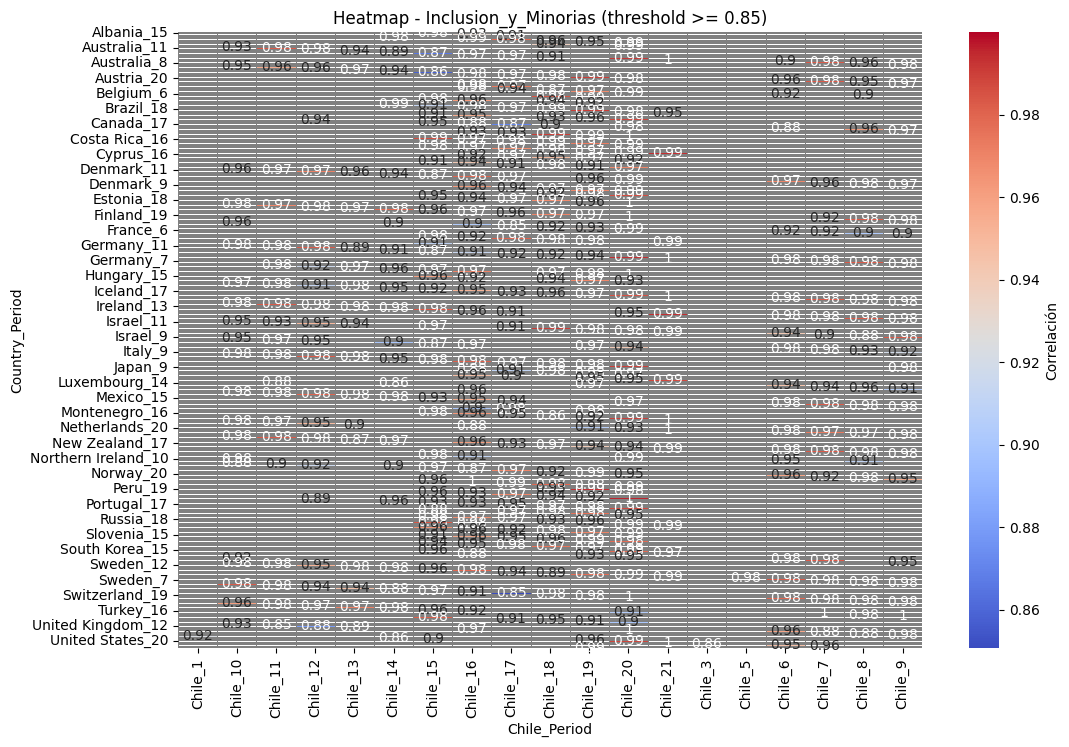

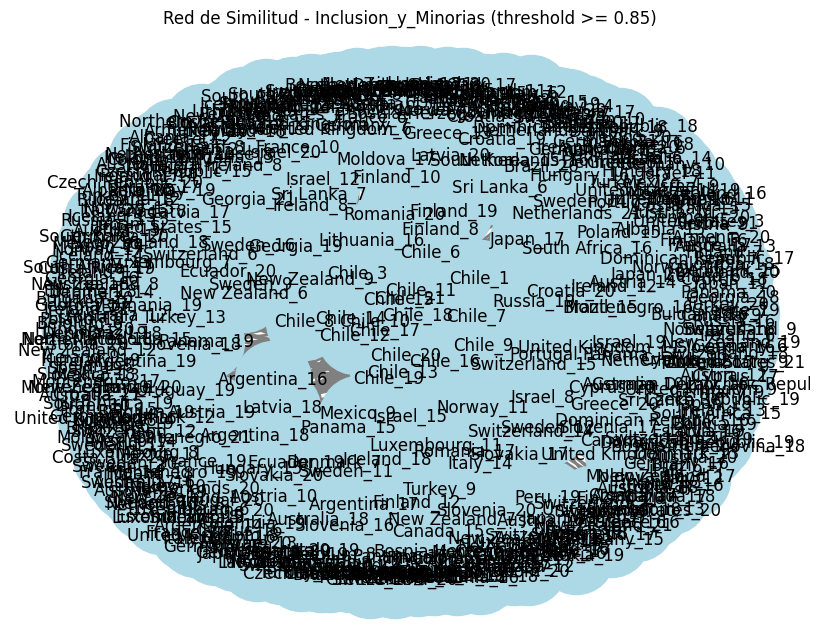

Se identificaron 811 clusters para el aspecto 'Inclusion_y_Minorias'.


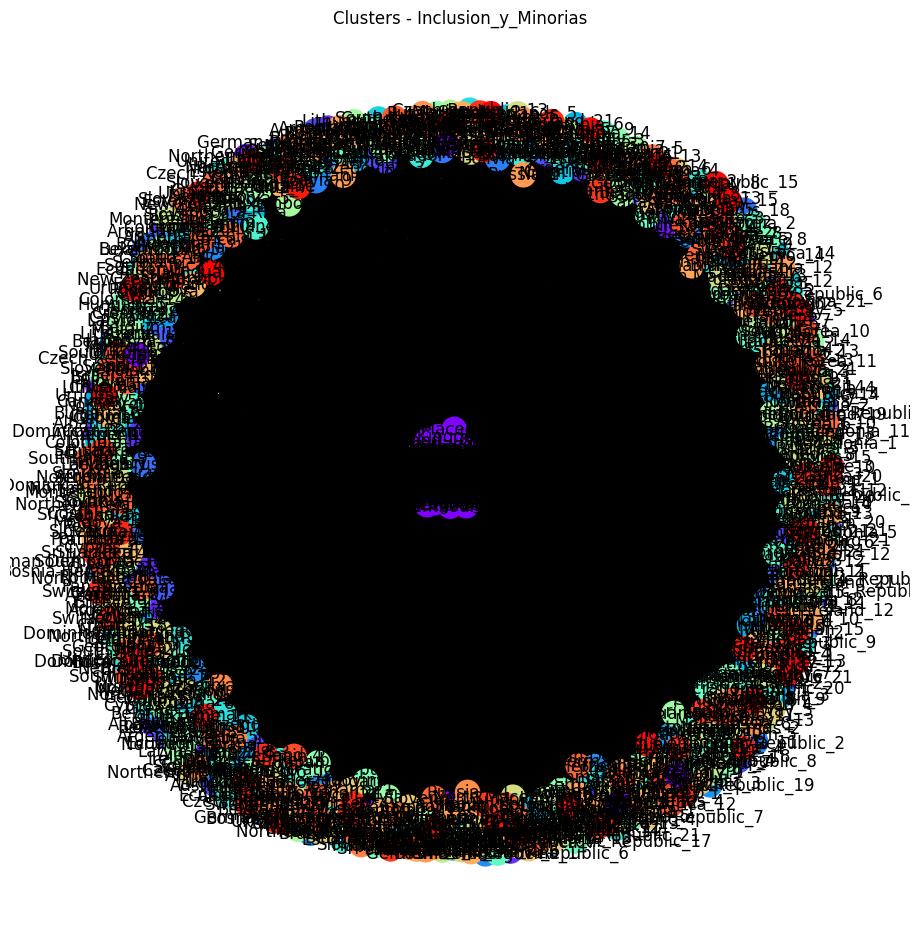

         Nodo  Cluster               Aspecto
0    Chile_15        7  Inclusion_y_Minorias
1  Albania_15        7  Inclusion_y_Minorias
2    Chile_16        7  Inclusion_y_Minorias
3    Chile_18        3  Inclusion_y_Minorias
4    Chile_19        3  Inclusion_y_Minorias
         Nodo  Degree_Centrality  Betweenness_Centrality  \
0    Chile_15           0.704125                     NaN   
1  Albania_15           0.004979                     0.0   
2    Chile_16           0.751067                     NaN   
3    Chile_18           0.844950                     NaN   
4    Chile_19           0.891892                     NaN   

   Eigenvector_Centrality               Aspecto  
0                0.191796  Inclusion_y_Minorias  
1                0.012993  Inclusion_y_Minorias  
2                0.198482  Inclusion_y_Minorias  
3                0.208648  Inclusion_y_Minorias  
4                0.212073  Inclusion_y_Minorias  

Analizando: Orden_y_Corrupcion


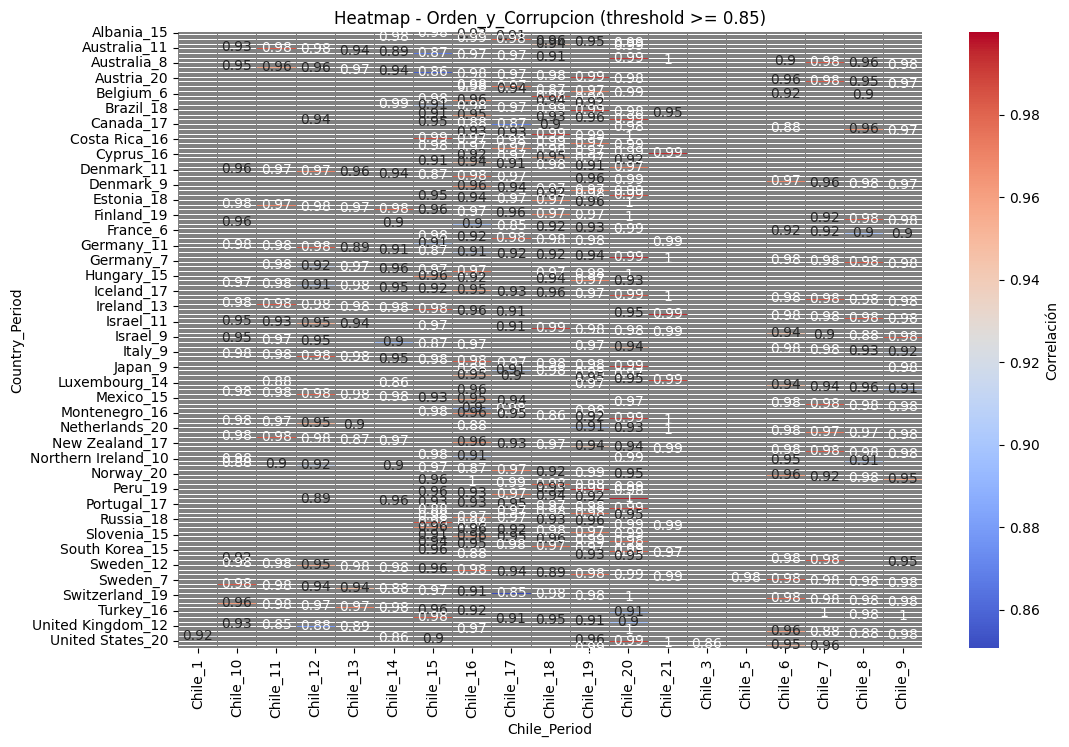

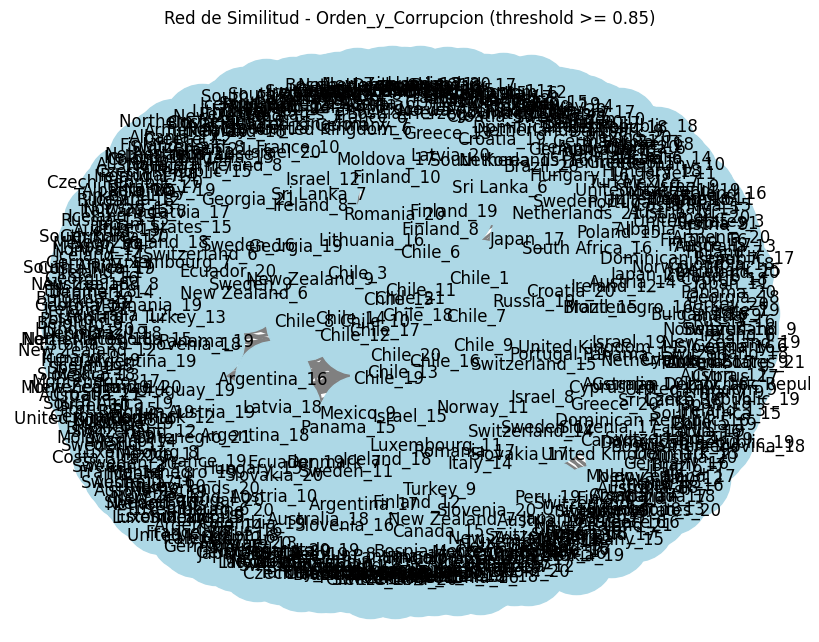

Se identificaron 811 clusters para el aspecto 'Orden_y_Corrupcion'.


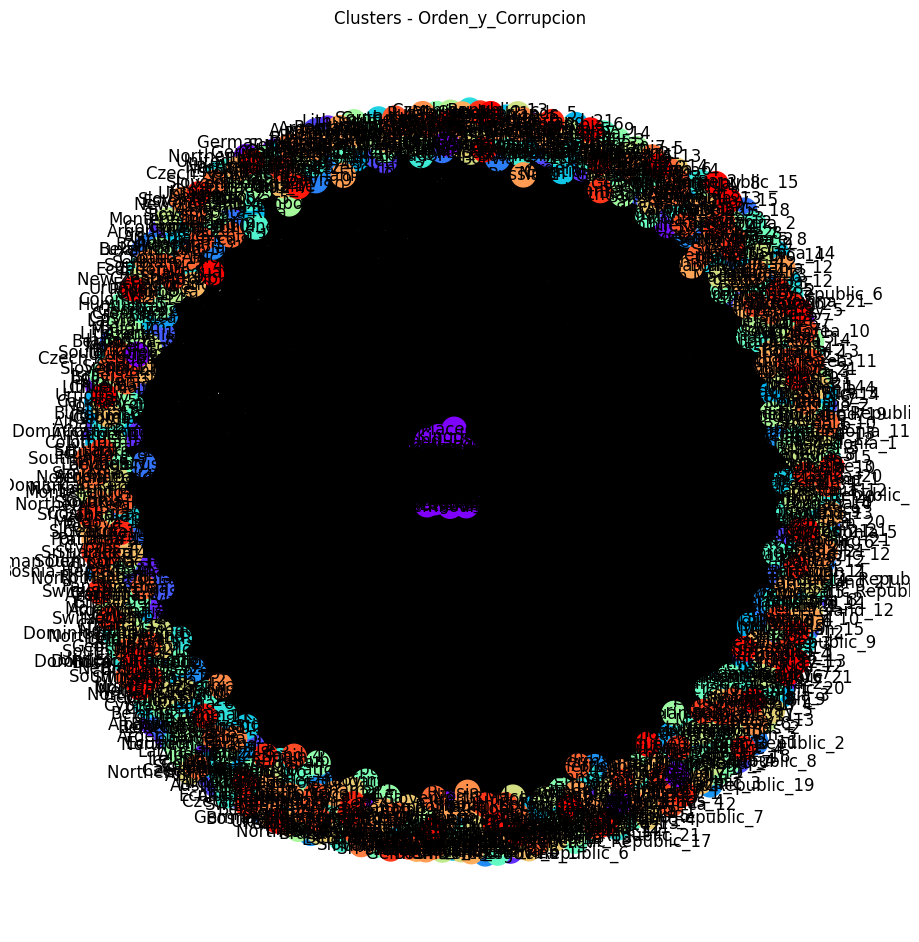

         Nodo  Cluster             Aspecto
0    Chile_15        7  Orden_y_Corrupcion
1  Albania_15        7  Orden_y_Corrupcion
2    Chile_16        7  Orden_y_Corrupcion
3    Chile_18        2  Orden_y_Corrupcion
4    Chile_19        2  Orden_y_Corrupcion
         Nodo  Degree_Centrality  Betweenness_Centrality  \
0    Chile_15           0.704125                     NaN   
1  Albania_15           0.004979                     0.0   
2    Chile_16           0.751067                     NaN   
3    Chile_18           0.844950                     NaN   
4    Chile_19           0.891892                     NaN   

   Eigenvector_Centrality             Aspecto  
0                0.191796  Orden_y_Corrupcion  
1                0.012993  Orden_y_Corrupcion  
2                0.198482  Orden_y_Corrupcion  
3                0.208648  Orden_y_Corrupcion  
4                0.212073  Orden_y_Corrupcion  

Analizando: Medio_Ambiente_y_Sostenibilidad


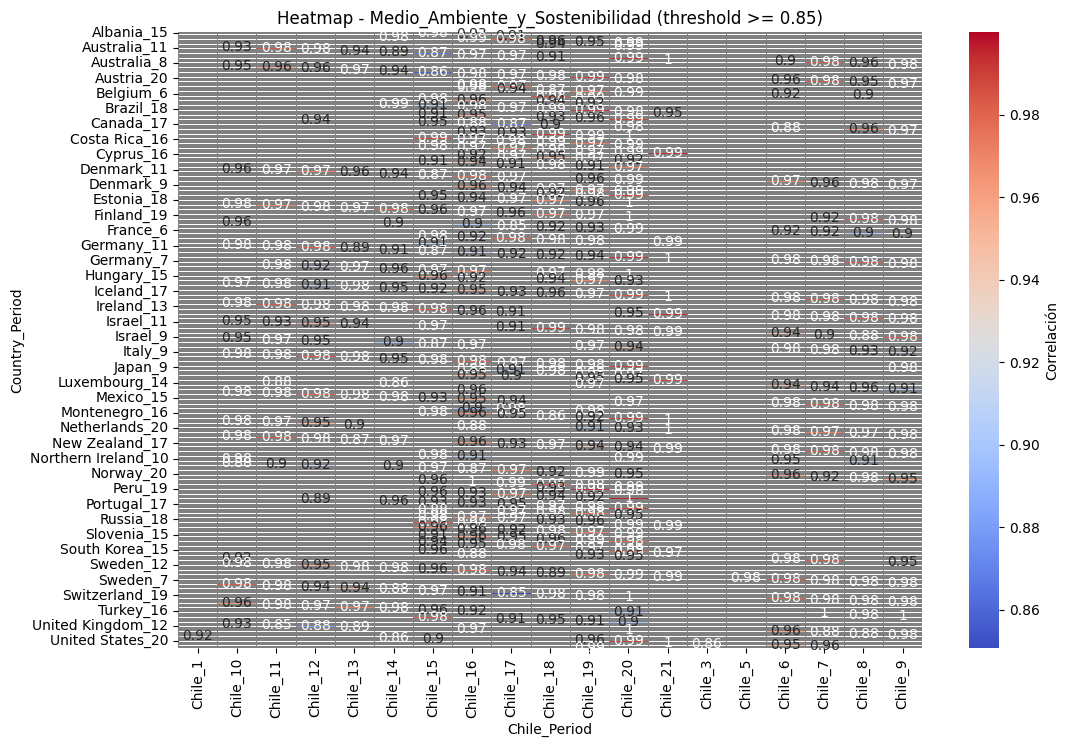

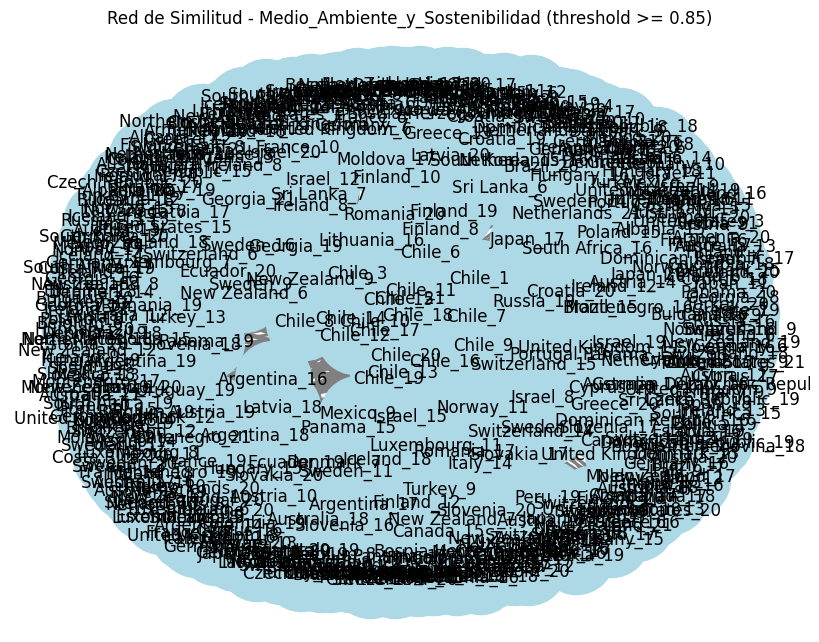

Se identificaron 811 clusters para el aspecto 'Medio_Ambiente_y_Sostenibilidad'.


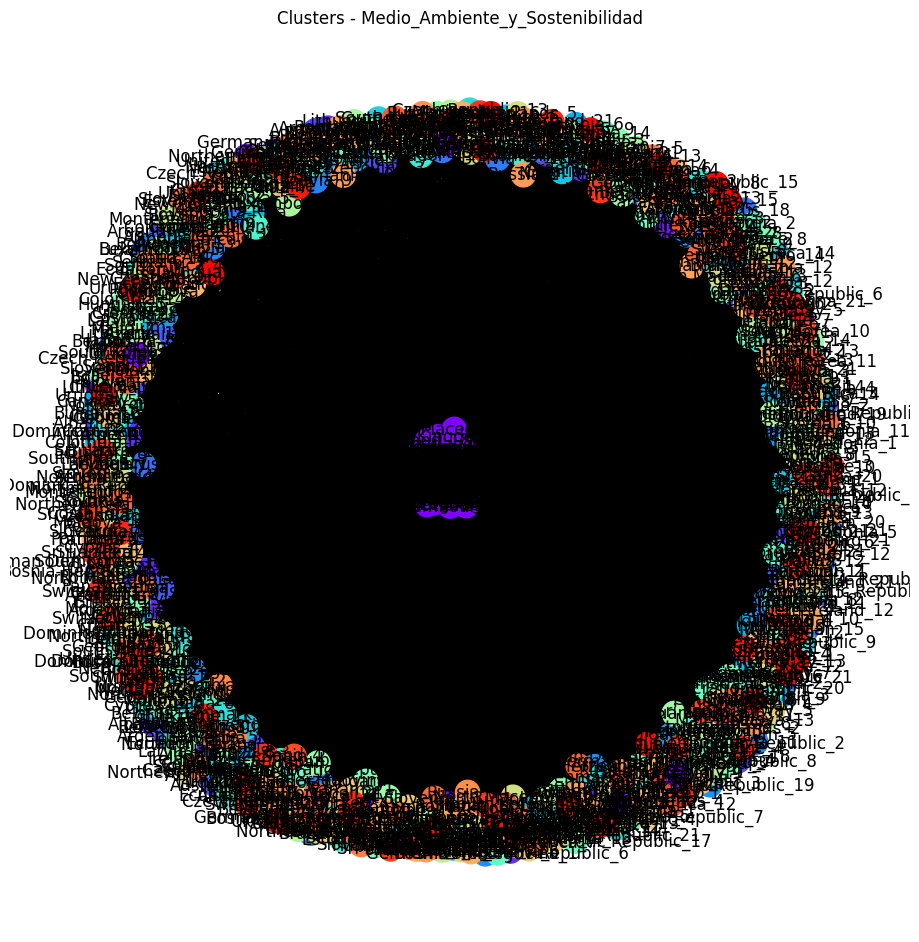

         Nodo  Cluster                          Aspecto
0    Chile_15        7  Medio_Ambiente_y_Sostenibilidad
1  Albania_15        7  Medio_Ambiente_y_Sostenibilidad
2    Chile_16        7  Medio_Ambiente_y_Sostenibilidad
3    Chile_18        2  Medio_Ambiente_y_Sostenibilidad
4    Chile_19        2  Medio_Ambiente_y_Sostenibilidad
         Nodo  Degree_Centrality  Betweenness_Centrality  \
0    Chile_15           0.704125                     NaN   
1  Albania_15           0.004979                     0.0   
2    Chile_16           0.751067                     NaN   
3    Chile_18           0.844950                     NaN   
4    Chile_19           0.891892                     NaN   

   Eigenvector_Centrality                          Aspecto  
0                0.191796  Medio_Ambiente_y_Sostenibilidad  
1                0.012993  Medio_Ambiente_y_Sostenibilidad  
2                0.198482  Medio_Ambiente_y_Sostenibilidad  
3                0.208648  Medio_Ambiente_y_Sostenibilidad 

In [ ]:
# Heatmap, Red de similaridad, Clusters, y métricas de centralidad

# Función para calcular correlaciones
def calcular_correlaciones(df, df_aspectos, threshold):
    """Calcula las correlaciones entre Chile y otros países para cada aspecto."""
    correlation_results = defaultdict(list)

    for _, row_aspecto in df_aspectos.iterrows():
        aspecto = row_aspecto['aspecto']
        variables = row_aspecto[['var_1', 'var_2', 'var_3', 'var_4']].dropna().tolist()

        # Filtrar los datos de Chile y otros países, seleccionando las columnas relevantes
        columnas_relevantes = ['countryname', 'ventana_5'] + variables
        df_chile = df[df['countryname'] == 'Chile'][columnas_relevantes].copy()
        df_otros = df[df['countryname'] != 'Chile'][columnas_relevantes].copy()

        # Iterar por cada país y calcular las correlaciones con Chile
        for _, row in df_otros.iterrows():
            country_period = row['countryname'] + '_' + str(row['ventana_5'])
            country_data = row[variables].dropna().astype(float)

            chile_periods = df_chile[df_chile['ventana_5'] >= row['ventana_5']]

            for _, chile_row in chile_periods.iterrows():
                chile_period = 'Chile_' + str(chile_row['ventana_5'])
                chile_data = chile_row[variables].dropna().astype(float)

                if len(country_data) == len(chile_data):
                    correlation = country_data.corr(chile_data)
                    correlation = 0 if pd.isna(correlation) else correlation
                else:
                    correlation = 0

                correlation_results[(aspecto, country_period, chile_period)].append(correlation)

    final_results = {
        key: np.mean(values) for key, values in correlation_results.items()
    }

    df_correlations = pd.DataFrame(
        list(final_results.items()), 
        columns=['Aspecto_Country_Period_And_Chile_Period', 'Correlation_with_Chile']
    )
    df_correlations[['Aspecto', 'Country_Period', 'Chile_Period']] = pd.DataFrame(
        df_correlations['Aspecto_Country_Period_And_Chile_Period'].tolist(), index=df_correlations.index
    )
    df_correlations.drop('Aspecto_Country_Period_And_Chile_Period', axis=1, inplace=True)

    df_correlations.to_excel("df_correlations.xlsx", index=False)

    return df_correlations

# Función para generar heatmap y red de similitud
def generar_heatmap_y_red(df_correlations, aspecto, threshold):
    df_filtered = df_correlations[df_correlations['Correlation_with_Chile'] >= threshold].copy()
    df_filtered['Chile_Period'] = df_filtered['Country_Period'].apply(lambda x: 'Chile_' + x.split('_')[1])
    df_filtered = df_filtered.groupby(['Country_Period', 'Chile_Period'], as_index=False).agg({'Correlation_with_Chile': 'mean'})

    heatmap_data = df_filtered.pivot(index='Country_Period', columns='Chile_Period', values='Correlation_with_Chile')

    plt.figure(figsize=(12, 8))
    sns.heatmap(heatmap_data, annot=True, cmap="coolwarm", linewidths=0.5, linecolor='gray', cbar_kws={'label': 'Correlación'})
    plt.title(f'Heatmap - {aspecto} (threshold >= {threshold})')
    plt.show()

    G = nx.Graph()
    for _, row in df_filtered.iterrows():
        nodo_chile = 'Chile_' + row['Chile_Period'].split('_')[1]
        nodo_pais = row['Country_Period']
        G.add_edge(nodo_chile, nodo_pais, weight=row['Correlation_with_Chile'])

    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(G, k=0.5, seed=42)
    nx.draw(G, pos, with_labels=True, node_size=3000, node_color='lightblue', edge_color='gray', width=2)
    plt.title(f'Red de Similitud - {aspecto} (threshold >= {threshold})')
    plt.show()

# Función para calcular clusters y centralidades
def calcular_clusters_y_centralidades(df_correlations, aspecto, threshold):
    G = nx.Graph()
    for _, row in df_correlations.iterrows():
        nodo_chile = 'Chile_' + row['Chile_Period'].split('_')[1]
        nodo_pais = row['Country_Period']
        G.add_edge(nodo_chile, nodo_pais, weight=abs(row['Correlation_with_Chile']))

    if G.number_of_nodes() == 0:
        print(f"No se encontraron nodos para el aspecto '{aspecto}' con el threshold >= {threshold}.")
        return None, None

    partition = community_louvain.best_partition(G)
    num_clusters = len(set(partition.values()))
    print(f"Se identificaron {num_clusters} clusters para el aspecto '{aspecto}'.")

    df_clusters = pd.DataFrame(partition.items(), columns=['Nodo', 'Cluster'])
    df_clusters['Aspecto'] = aspecto

    plt.figure(figsize=(9, 9))
    pos = nx.spring_layout(G, seed=42)
    node_colors = [partition[node] for node in G.nodes()]
    nx.draw(G, pos, node_color=node_colors, cmap=plt.cm.rainbow, with_labels=True, node_size=300)
    plt.title(f'Clusters - {aspecto}')
    plt.show()

    degree = nx.degree_centrality(G)
    betweenness = nx.betweenness_centrality(G, weight='weight')
    eigenvector = nx.eigenvector_centrality(G, max_iter=1000)

    df_centralities = pd.DataFrame({
        'Nodo': list(degree.keys()),
        'Degree_Centrality': list(degree.values()),
        'Betweenness_Centrality': list(betweenness.values()),
        'Eigenvector_Centrality': list(eigenvector.values()),
        'Aspecto': aspecto
    })

    return df_clusters, df_centralities

# Función principal para ejecutar el análisis
def ejecutar_analisis_por_aspecto(df, df_aspectos, threshold):
    for aspecto in df_aspectos['aspecto']:
        print(f'\nAnalizando: {aspecto}')
        df_correlations = calcular_correlaciones(df, df_aspectos, threshold)
        generar_heatmap_y_red(df_correlations, aspecto, threshold)
        df_clusters, df_centralities = calcular_clusters_y_centralidades(df_correlations, aspecto, threshold)
        print(df_clusters.head())
        print(df_centralities.head())

import pandas as pd

# Crear el DataFrame 'df_aspectos' con los aspectos y las variables asociadas
data_aspectos = {
    'aspecto': ['Inclusion_y_Minorias', 'Orden_y_Corrupcion', 'Medio_Ambiente_y_Sostenibilidad'],
    'var_1': ['per503', 'per605_1', 'per503'],
    'var_2': ['per705', 'per605_2', 'per705'],
    'var_3': ['per201_2', 'per304', 'per201_2'],  # None indica que no hay una tercera variable para el aspecto
    'var_4': [None, None, None]  # Ningún aspecto tiene cuarta variable
}

df_aspectos = pd.DataFrame(data_aspectos)

# Mostrar el DataFrame 'df_aspectos' para verificar su contenido
print(df_aspectos)


# Ejecutar el análisis
ejecutar_analisis_por_aspecto(df_5_extended, df_aspectos, threshold)


#### 14 Oct 2024
#### Temas por revisare en este Notebook:
*   * Ver porqué los últimos feature vectors usados dan correlaciones -1, 0 ó 1
*   * En este notebook dejé repetidos el tema 1 y tema 3: el notebook corre bien, y las correlaciones son normales
*   **NOTA: El número de nodos es demasiado grande (811) para un threshiold de 0.85**
*   * Acuerdo con profesora guía:
*   * 1.Analizar las curvas del notebook Pruebas_Chile, usando valores absolutos y comparar
*   * 2.Validar los datos nuevamente y ver si explican bien la realidad
*   * 3.Luego de 1 y 2: 
*       * Elegir un tema
*       * Hacer la red de correlaciones de nodos todos los países con todos los países (debiera ser una red cuadrada, con 1 en la diagonal)
*       * Fijar un threshold
*       * Fijar una ventana (quedará un nodo por país). Debe quedar un nodo por país.
*       * Analizar 